# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


def get_calibration_parameters():
    """
    get parameters for camera calibration from chessboard images
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints    


## Apply a distortion correction to raw images

In [2]:
def get_undistorted_image(image, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[0:2], None, None)
    return cv2.undistort(image, mtx, dist)

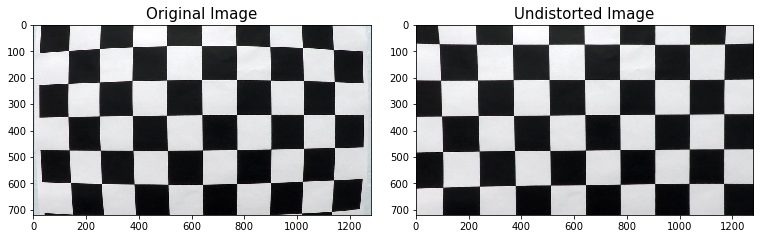

In [3]:
image = cv2.imread("camera_cal/calibration1.jpg")
objpoints, imgpoints = get_calibration_parameters()
undistorted = get_undistorted_image(image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undistorted, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig("images/undistorted_board.png",bbox_inches="tight")

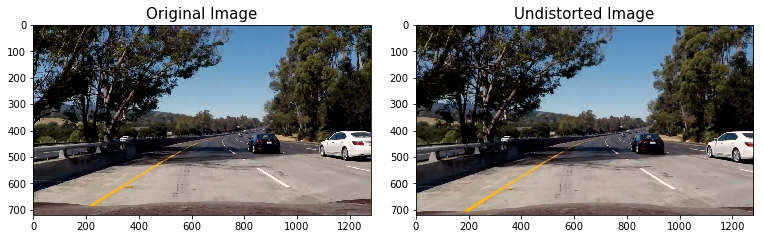

In [4]:
image = mpimg.imread("test_images/test5.jpg")
objpoints, imgpoints = get_calibration_parameters()
undistorted = get_undistorted_image(image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig("images/undistorted.png",bbox_inches="tight")

## Apply a perspective transform to raw image 

In [5]:
def get_warped_area_image(image):
    imshape = image.shape
    
    lr_margin = 300
    tb_margin = 30
    vertices = np.array([[(lr_margin, imshape[0]-tb_margin),(600, 450), (680, 450), (imshape[1]-lr_margin, imshape[0]-tb_margin)]], dtype=np.int32)

    plotted_image = cv2.polylines(image.copy(), vertices, 1, 255, thickness=3)
    #plt.imshow(plotted_image)
    return plotted_image

In [6]:
def get_perspective_transformed_image(image, inv=0, plot=0):
    imshape = image.shape
    lr_margin = 300 # left and right margin
    tb_margin = 30 # top and bottom margin
    dst_margin = 350 # destination 
    
    source = np.float32([[(lr_margin, imshape[0]-tb_margin),(600, 450), (680, 450), (imshape[1]-lr_margin, imshape[0]-tb_margin)]])
    destination = np.float32([[dst_margin, imshape[0]], [dst_margin, 0], [imshape[1] - dst_margin, 0], [imshape[1] - dst_margin, imshape[0]]])
    M = cv2.getPerspectiveTransform(source, destination)
    
    if inv == 0:
        transformed = cv2.warpPerspective(image, M, (imshape[1],  imshape[0]))
    elif inv == 1:
        transformed = cv2.warpPerspective(image, M, (imshape[1],  imshape[0]), flags=cv2.WARP_INVERSE_MAP)
   
    if plot == 1:
        warped_vertices = np.array([[(dst_margin, imshape[0]), (dst_margin, 0), (imshape[1] - dst_margin, 0), (imshape[1] - dst_margin, imshape[0])]], dtype=np.int32)   
        transformed = cv2.polylines(transformed.copy(), warped_vertices, 1, 255, thickness=3)

    return transformed

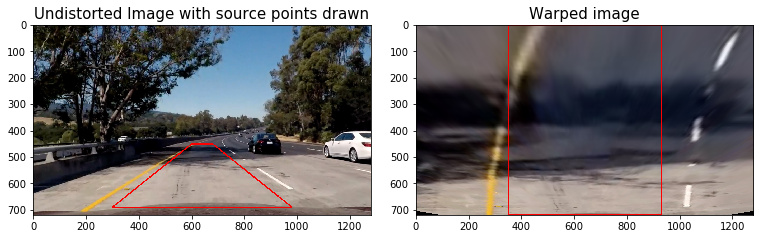

In [7]:
# verified perspective transform
plotted = get_warped_area_image(undistorted)
warped = get_perspective_transformed_image(undistorted, plot=1)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
f.tight_layout()
ax1.imshow(plotted)
ax1.set_title('Undistorted Image with source points drawn', fontsize=15)
ax2.imshow(warped)
ax2.set_title('Warped image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig("images/warped.png",bbox_inches="tight")

## Create a thresholded binary image

In [8]:
def get_color_threshold_binary_image(image,  thresh=(150, 250)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


def get_absolute_sobel_threshold_binary_image(image, orient='x', thresh=(20, 100)):
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

    
def get_magnitude_threshold_binary_image(image, sobel_kernel=3, thresh=(30, 100)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


def get_dicrection_threshold_binary_image(image, sobel_kernel=15, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    gradmag = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return binary_output

In [9]:
def get_binary_image(image):
    """
    Create thresholded binary image using color and gradient
    """
    color_th_binary = get_color_threshold_binary_image(image, thresh=(120, 255))
    mag_th_binary = get_magnitude_threshold_binary_image(image, sobel_kernel=7, thresh=(20, 255))
    abs_sobel_x_th_binary = get_absolute_sobel_threshold_binary_image(image, orient='x', thresh=(30, 100))
    abs_sobel_y_th_binary = get_absolute_sobel_threshold_binary_image(image, orient='y', thresh=(30, 100))

    #dic_th_binary = get_dicrection_threshold_binary_image(image,sobel_kernel=31, thresh=(50*np.pi/180, 60*np.pi/180))

    binary_image = np.zeros_like(color_th_binary)
    #binary_image[(color_th_binary == 1) | (mag_th_binary == 1) | (dic_th_binary == 1)] = 1
    binary_image[(color_th_binary == 1) | (mag_th_binary == 1) | (abs_sobel_x_th_binary == 1)] = 1
    #binary_image[(color_th_binary == 1) | (mag_th_binary == 1) | (abs_sobel_th_binary == 1) | (dic_th_binary)] = 1
    binary_image[(abs_sobel_y_th_binary == 1)] = 0

    return binary_image

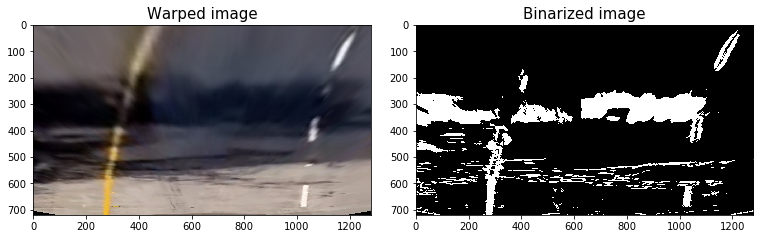

In [10]:
# binarize
warped = get_perspective_transformed_image(undistorted)
processed = get_binary_image(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Warped image', fontsize=15)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Binarized image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig("images/binarize.png",bbox_inches="tight")

##  Shadow detection and removal.

In [11]:
# A robust approach for road detection with shadow removal technique
def get_removed_shadow_binary_image(image, th=0.7):
    hsv = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    v = hsv[:,:,2]
    
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    ratio_image = np.zeros_like(gray)
    ratio_image[(gray >= ( h.mean()*th+1 / v.mean()*th+1 ))] = 1

    ret, shadow = cv2.threshold(ratio_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    return shadow

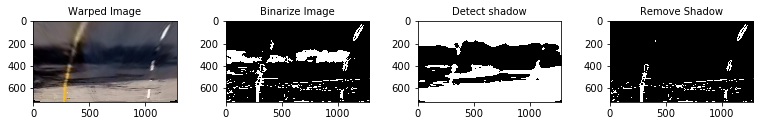

In [12]:
warped = get_perspective_transformed_image(undistorted)
processed = get_binary_image(warped)

hsv = cv2.cvtColor(warped.copy(), cv2.COLOR_RGB2HSV)
h = hsv[:,:,0]
v = hsv[:,:,2]
th = 0.7

gray = cv2.cvtColor(warped.copy(), cv2.COLOR_RGB2GRAY)
ratio_image = np.zeros_like(gray)
ratio_image[(gray >= ( h.mean()*th+1 / v.mean()*th+1 ))] = 1

ret, shadow = cv2.threshold(ratio_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

f, (ax0, ax1, ax2 , ax3) = plt.subplots(1, 4, figsize=(10, 6))
f.tight_layout()
ax0.imshow(warped)
ax0.set_title('Warped Image', fontsize=10)

ax1.imshow(processed, cmap='gray')
ax1.set_title('Binarize Image', fontsize=10)
ax2.imshow(shadow, cmap='gray')
ax2.set_title('Detect shadow', fontsize=10)

processed[(shadow == 0)] = 0
ax3.imshow(processed, cmap='gray')
ax3.set_title('Remove Shadow', fontsize=10)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig("images/shadow_detect.png",bbox_inches="tight")

## Varify all preprocessing before window search

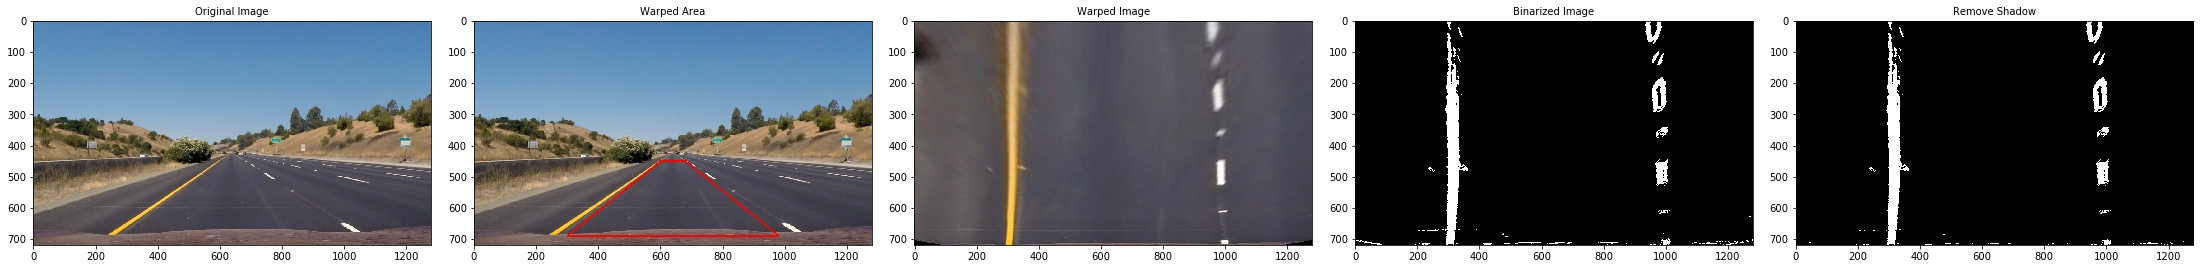

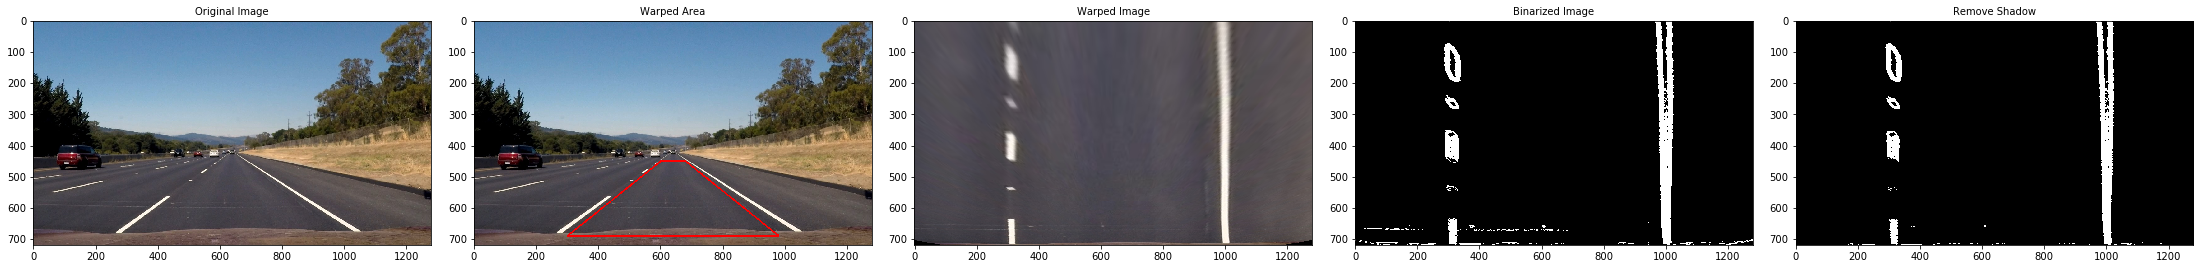

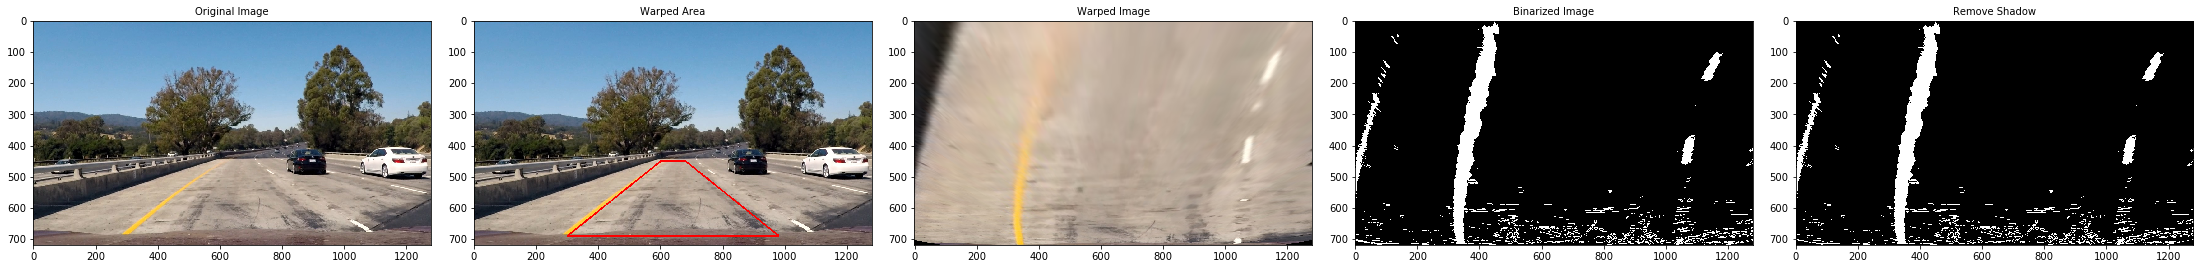

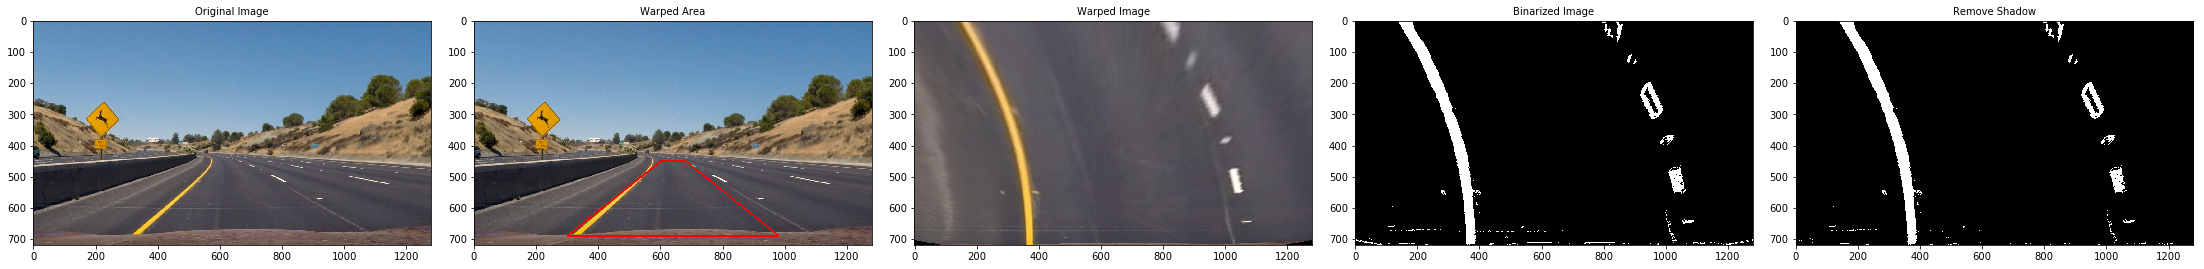

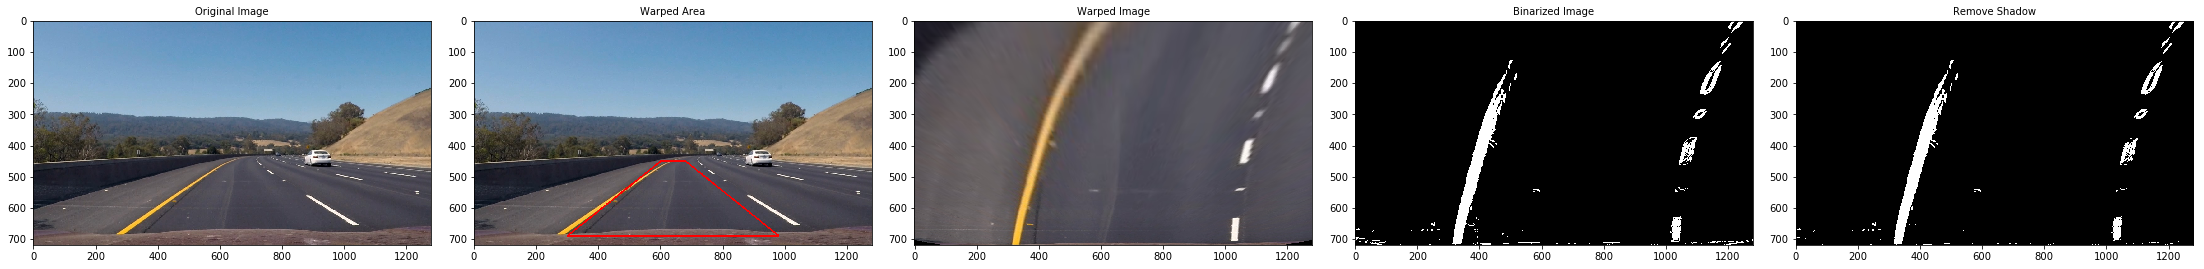

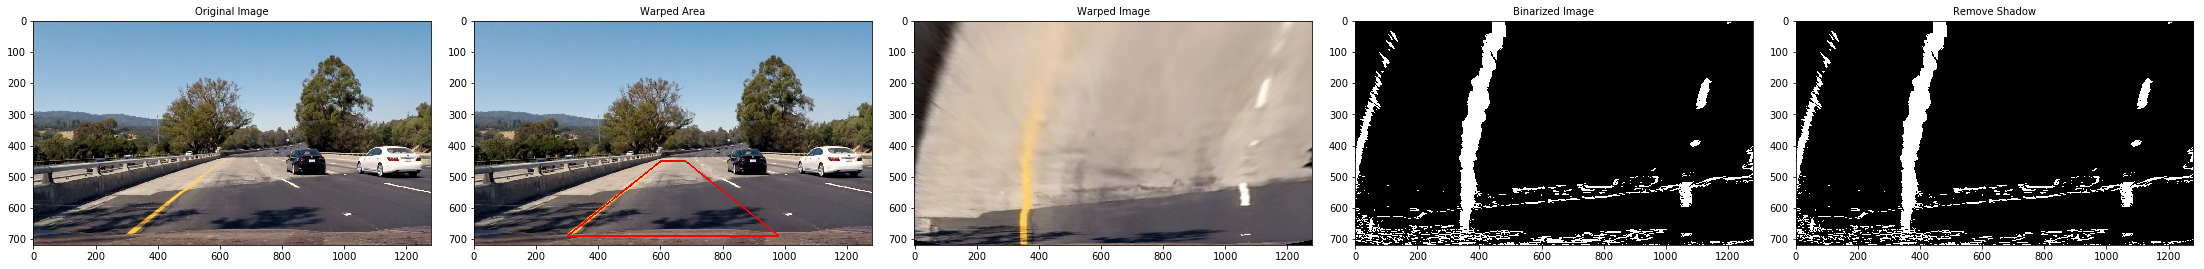

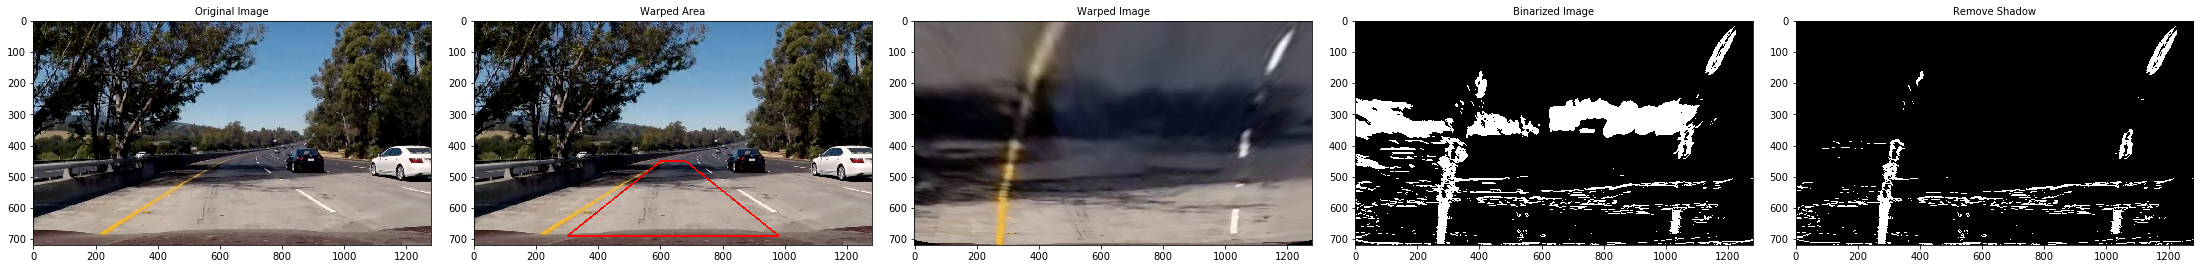

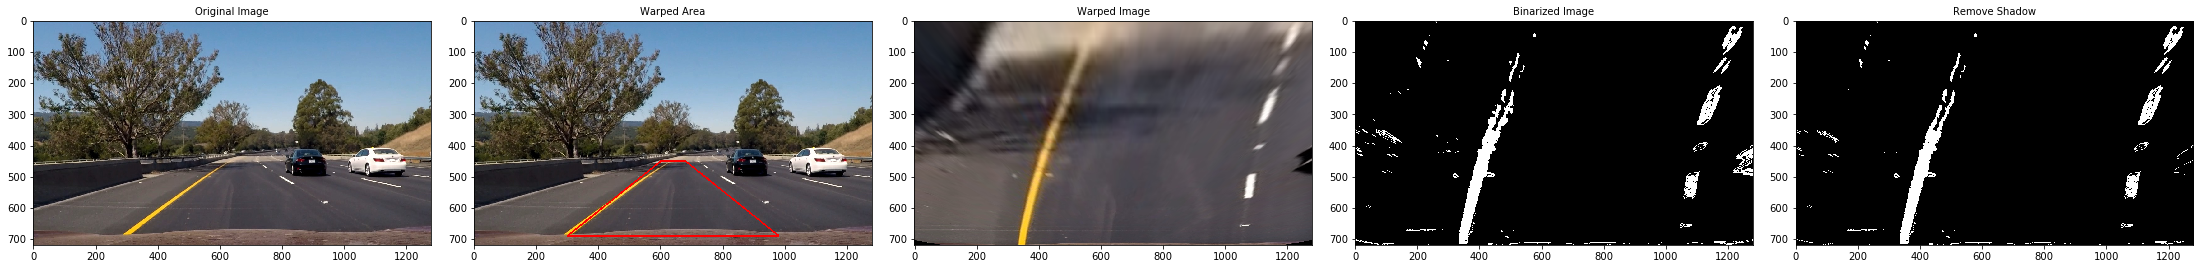

In [13]:
# visualizing preprocessed images,
# Perspective transform -> Binalize
image_list = glob.glob('test_images/*.jpg')

for fname in image_list:
    image = mpimg.imread(fname)
    plotted = get_warped_area_image(image)
    warped = get_perspective_transformed_image(image)
    processed = get_binary_image(warped)
    shadow = get_removed_shadow_binary_image(warped)

    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30, 18))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(plotted)
    ax2.set_title('Warped Area', fontsize=10)
    ax3.imshow(warped)
    ax3.set_title('Warped Image', fontsize=10)
    ax4.imshow(processed, cmap='gray')
    ax4.set_title('Binarized Image', fontsize=10)
    
    processed[(shadow == 0)] = 0
    ax5.imshow(processed, cmap='gray')
    ax5.set_title('Remove Shadow', fontsize=10)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    output_name = 'fix_' + fname.split('/')[-1]
    #plt.savefig(output_name, bbox_inches="tight")

## Detect lane pixels and fit to find the lane boundary.

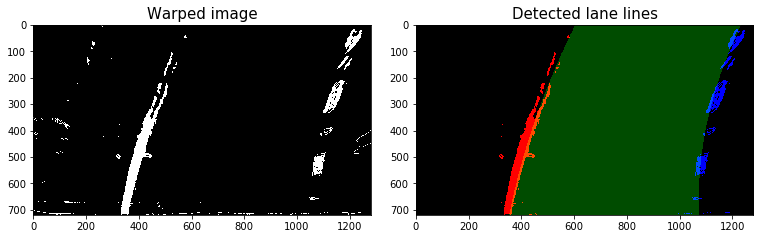

In [14]:
import AdvLaneLine
import importlib

importlib.reload(AdvLaneLine)

getLL = AdvLaneLine.getLaneLine()
getLL.sliding_window_search(processed)
plotted = getLL.get_plotted_lane_lines_binalized_image(processed)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
f.tight_layout()
ax1.imshow(processed, cmap='gray')
ax1.set_title('Warped image', fontsize=15)
ax2.imshow(plotted, cmap='gray')
ax2.set_title('Detected lane lines', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt.savefig("images/detect_lanes.png",bbox_inches="tight")

## Determine the curvature of the lane and vehicle position with respect to center.

In [15]:
center_curve = getLL.determine_curvature(processed)
print("center_curve:{:.2f}".format(center_curve))

center_curve:398.41


In [16]:
v_position = getLL.get_vehicle_position()
print(v_position)

0.462412556777


## Warp the detected lane boundaries back onto the original image.

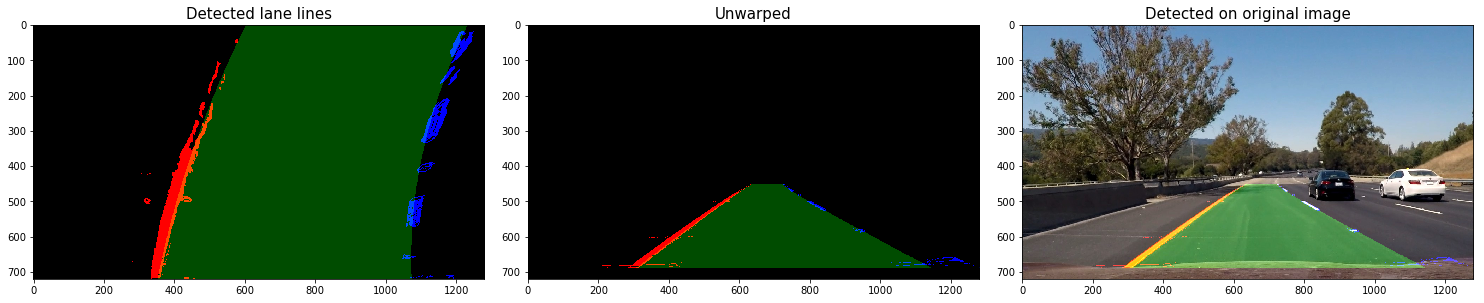

In [17]:
invimg = get_perspective_transformed_image(plotted, inv=1)
ans = cv2.addWeighted(image, 1, invimg, 1, 0)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 12))
f.tight_layout()
ax1.imshow(plotted, cmap='gray')
ax1.set_title('Detected lane lines', fontsize=15)
ax2.imshow(invimg, cmap='gray')
ax2.set_title('Unwarped', fontsize=15)

ax3.imshow(ans, cmap='gray')
ax3.set_title('Detected on original image', fontsize=15)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt.savefig("images/unwarped_lanes.png",bbox_inches="tight")

## Test on Video
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [18]:
# from datetime import datetime
import AdvLaneLine
import importlib
importlib.reload(AdvLaneLine)

objpoints, imgpoints = get_calibration_parameters()
AdvLL = AdvLaneLine.getLaneLine()

def pipeline(image, objpoints=objpoints, imgpoints=imgpoints, AdvLaneLine=AdvLaneLine):
    undistorted = get_undistorted_image(image, objpoints, imgpoints)
    warped = get_perspective_transformed_image(undistorted)
    binarized = get_binary_image(warped)
    shadow = get_removed_shadow_binary_image(warped)
    
    # Remove side of warped image to prevent misrecognition
    #binarized[:, 0:150] = 0
    #binarized[:, 1150:] = 0
    
    # Remove shadow
    binarized[(shadow == 0)] = 0
    
    AdvLL.sliding_window_search(binarized, margin=70)

    detected = AdvLL.get_plotted_lane_lines_binalized_image(binarized)
    
    center_curve = AdvLL.determine_curvature(detected)
    vehicle_position = AdvLL.get_vehicle_position()
    
    # Warp the detected lane boundaries back onto the original image
    unwarped = get_perspective_transformed_image(detected, inv=1)
    result = cv2.addWeighted(image, 1, unwarped, 1, 0)

    center_curve_text = "Radius of curvature = {:.2f}(m)".format(center_curve)

    if vehicle_position >= 0:
        vehicle_position_text = "Vehicle is {:.2f}m left of center".format(abs(vehicle_position))
    else:
        vehicle_position_text = "Vehicle is {:.2f}m right of center".format(abs(vehicle_position))
    
    cv2.putText(result, center_curve_text, (20,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),3, cv2.LINE_AA)
    cv2.putText(result, vehicle_position_text, (20,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),3, cv2.LINE_AA)

    return result

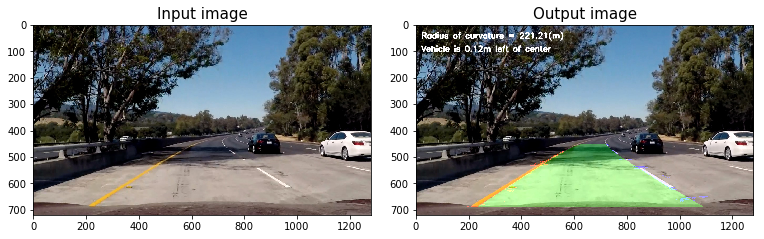

In [19]:
image = mpimg.imread('test_images/test5.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
f.tight_layout()
ax1.imshow(image, cmap='gray')
ax1.set_title('Input image', fontsize=15)
ax2.imshow(pipeline(image), cmap='gray')
ax2.set_title('Output image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'result_project_video.mp4'
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)